In [1]:
__depends__ = []
__dest__ = []

This notebook showcases the analysis applied to LLC outputs. Here the calculations are performed for a single snapshot. The full LLC model outputs can be obtained from the [ECCO Project](http://ecco2.org/llc_hires/). All fields used in this paper take about 700 GB!

The analysis leverage on other pieces of code developed by the first author: [llctools](https://github.com/crocha700/llctools) and [pyspec](https://github.com/pyspec/pyspec). 

In [19]:
import numpy as np
import scipy as sp
from scipy import interpolate

import matplotlib.pyplot as plt
%matplotlib inline

import cmocean

import seawater as sw

from llctools import llc_model
from pyspec import spectrum as spec

In [3]:
grid_path = '../data/llc/2160/grid/'
data_path = '../data/llc/2160/uv/'

In [4]:
#  Kuroshio Extension model class
m = llc_model.LLCRegion(grid_dir=grid_path,data_dir=data_path,Nlon=480,Nlat=466,Nz=1)

In [5]:
m.load_grid()

In [6]:
# model sub-region surface fields files
fileu = m.data_dir+'U_480x466x1.20110308T220000'
filev = m.data_dir+'V_480x466x1.20110308T220000'
fileeta = m.data_dir[:-3]+'Eta/Eta_480x466x1.20110308T220000'

In [7]:
time_string = fileu[-15:]
time=llc_model.parse_time(time_string)
time

datetime.datetime(2011, 3, 8, 22, 0)

In [8]:
# important note: U,V are relative to the LLC model grid, 
#                 not geostrophical coordinates. Thus, on
#                 faces 4 and 5, U = meridional component
#                 and V = -zonal component (see Dimitris's llc.readme).
u, v, eta = m.load_2d_data(filev),  -m.load_2d_data(fileu), m.load_2d_data(fileeta)

In [9]:
lon,lat = m.lon[m.Nlat/2],m.lat[:,m.Nlon/2]

# create a regular Cartesian grid
dd = 6. # grid spacing [km]
dlon =  dd/111.320*np.cos(np.abs(m.lat[m.Nlat/2,m.Nlon/2])*np.pi/180.)
dlat =  dd/110.574

lonimin,lonimax = lon.min()+dlon,lon.max()-dlon
latimin,latimax = lat.min()+dlat,lat.max()-dlat
 
loni = np.arange(m.lon.min(),m.lon.max()+dlon,dlon)
lati = np.arange(m.lat.min(),m.lat.max()+dlat,dlat)

long,latg = np.meshgrid(loni,lati)
f0 = sw.f(latg)

/Users/crocha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/crocha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [10]:
interpu, interpv, interpeta = sp.interpolate.interp2d(lon,lat,u), sp.interpolate.interp2d(lon,lat,v), sp.interpolate.interp2d(lon,lat,eta)

In [11]:
ui, vi,etai = interpu(loni,lati), interpv(loni,lati),  interpeta(loni,lati)

# Vorticity, divergence, and rate of strain

In [153]:
def calc_gradu(u,v,dd = 6.):

    uy,ux = np.gradient(u,dd,dd)
    vy,vx = np.gradient(v,dd,dd)
    
    vort, div, strain = (vx - uy), ux+vy, ( (ux-vy)**2 + (vx+uy)**2  )**.5

    return vort, div, strain

# double mirror ui and vi
def double_mirror(a,forward='True'):
    if forward:
        A = np.hstack([a,np.fliplr(a)])
        A = np.vstack([A,np.fliplr(A)])
    else:
        iy,ix = a.shape
        A = a[:iy//2,:ix//2]
        
    return A

def calc_gradu2(u,v,dd = 6.):

    u, v = double_mirror(u), double_mirror(v)
    
    iy,ix = u.shape
    Lx, Ly = (ix-1)*dd, (iy-1)*dd
    dk = 1./Lx
    dl = 1./Ly
    
    l = 2*np.pi*dl*np.append( np.arange(0.,iy//2), np.arange(-iy//2,0.) )
    k = 2*np.pi*dk*np.arange(0.,ix//2+1)
    k,l = np.meshgrid(k,l)
    
    uh, vh = np.fft.rfft2(u), np.fft.rfft2(v)
    
    ux, uy = np.fft.irfft2(1j*k*uh), np.fft.irfft2(1j*l*uh)
    vx, vy = np.fft.irfft2(1j*k*vh), np.fft.irfft2(1j*l*vh)

    vort, div, strain = (vx - uy), ux+vy, ( (ux-vy)**2 + (vx+uy)**2  )**.5 
    
    return vort, div, strain

In [154]:
vort, div, strain = calc_gradu(ui,vi,dd = 6.e3)
vort, div, strain = vort/f0, div/f0, strain/f0

In [177]:
vort2, div2, strain2 = calc_gradu2(ui,vi,dd = 6.e3)
vort2,div2, strain2 = double_mirror(vort2,forward=False),double_mirror(div2,forward=False), double_mirror(strain2,forward=False)
vort2, div2, strain2 = vort2/f0, div2/f0, strain2/f0

In [178]:
vort.mean()/np.abs(vort).max(), div.mean()/np.abs(div).max(), strain.mean()/np.abs(strain).max()

(-0.00037886423565867484, -0.00046198152619174483, 0.088461550414987961)

In [157]:
vort2.mean()/np.abs(vort2).max(), div2.mean()/np.abs(div2).max(), strain2.mean()/np.abs(strain2).max()

(0.00013117318566107465, 0.00031641049416569403, 0.083419138252587746)

([], <a list of 0 Text yticklabel objects>)

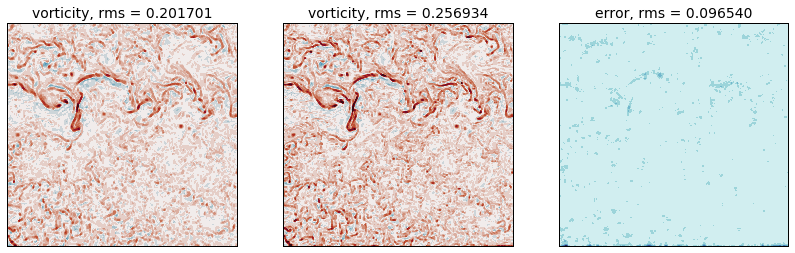

In [169]:
fig = plt.figure(figsize=(14,4))

cv = np.linspace(-1.5,1.5,20)
cd = np.linspace(-.5,.5,20)
cs = np.linspace(0.,1.5,10)

ax = fig.add_subplot(131)
plt.contourf(vort,cv,vmin=cv.min(),vmax=cv.max(),cmap=cmocean.cm.balance,extend='both')
plt.title('vorticity, rms = %f' % rms(vort))
#plt.colorbar()
plt.xticks([]); plt.yticks([])
ax = fig.add_subplot(132)
plt.contourf(vort2,cv,vmin=cv.min(),vmax=cv.max(),cmap=cmocean.cm.balance,extend='both')
plt.title('vorticity, rms = %f' % rms(vort2))
#plt.colorbar()
plt.xticks([]); plt.yticks([])

ax = fig.add_subplot(133)
plt.contourf(np.abs((vort2-vort)/np.max(vort2)),np.linspace(0,1.,10),vmin=0,vmax=1.,cmap=cmocean.cm.ice_r)
plt.title('error, rms = %f' % rms(vort2-vort))
#plt.colorbar()
plt.xticks([]); plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

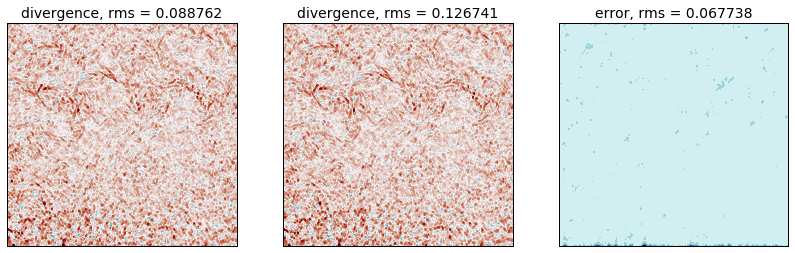

In [173]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(131)
plt.contourf(div,cd,vmin=cd.min(),vmax=cd.max(),cmap=cmocean.cm.balance,extend='both')
plt.title('divergence, rms = %f' % rms(div))
#plt.colorbar()
plt.xticks([]); plt.yticks([])
ax = fig.add_subplot(132)
plt.contourf(div,cd,vmin=cd.min(),vmax=cd.max(),cmap=cmocean.cm.balance,extend='both')
plt.title('divergence, rms = %f' % rms(div2))
#plt.colorbar()
plt.xticks([]); plt.yticks([])

ax = fig.add_subplot(133)
plt.contourf(np.abs((div2-div)/np.max(div2)),np.linspace(0,1.,10),vmin=0,vmax=1.,cmap=cmocean.cm.ice_r)
plt.title('error, rms = %f' % rms(div2-div))
#plt.colorbar()
plt.xticks([]); plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

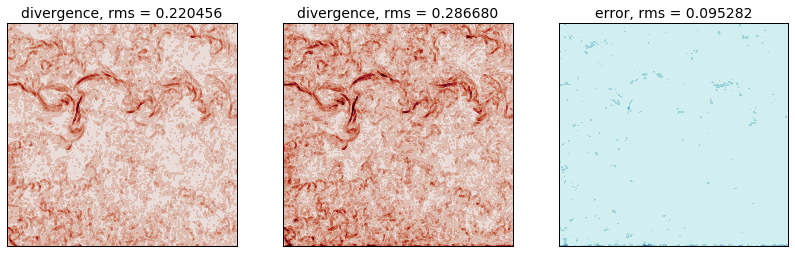

In [176]:
fig = plt.figure(figsize=(14,4))

ax = fig.add_subplot(131)
plt.contourf(strain,cs,vmin=cs.min(),vmax=cs.max(),cmap=cmocean.cm.amp,extend='both')
plt.title('divergence, rms = %f' % rms(strain))
#plt.colorbar()
plt.xticks([]); plt.yticks([])
ax = fig.add_subplot(132)
plt.contourf(strain2,cs,vmin=cs.min(),vmax=cs.max(),cmap=cmocean.cm.amp,extend='both')
plt.title('divergence, rms = %f' % rms(strain2))
#plt.colorbar()
plt.xticks([]); plt.yticks([])

ax = fig.add_subplot(133)
plt.contourf(np.abs((strain2-strain)/np.max(strain2)),np.linspace(0,1.,10),vmin=0,vmax=1.,cmap=cmocean.cm.ice_r)
plt.title('error, rms = %f' % rms(strain2-strain))
#plt.colorbar()
plt.xticks([]); plt.yticks([])

In [14]:
def rms(field):
    return ((field**2).mean())**.5

### Quick-and-dirty, sanity-check plots

([], <a list of 0 Text yticklabel objects>)

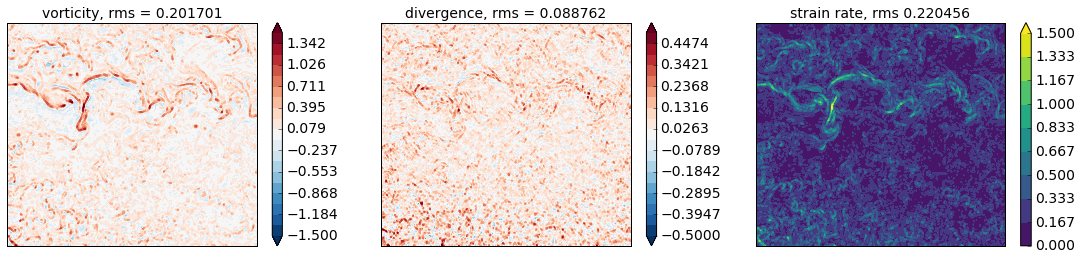

In [15]:
cv = np.linspace(-1.5,1.5,20)
cd = np.linspace(-.5,.5,20)
cs = np.linspace(0.,1.5,10)

fig = plt.figure(figsize=(19,4))

ax = fig.add_subplot(131)
plt.contourf(vort,cv,vmin=cv.min(),vmax=cv.max(),cmap='RdBu_r',extend='both')
plt.title('vorticity, rms = %f' % rms(vort))
plt.colorbar()
plt.xticks([]); plt.yticks([])

ax = fig.add_subplot(132)
plt.title('divergence, rms = %f' %  rms(div))
plt.contourf(div,cd,vmin=cd.min(),vmax=cd.max(),cmap='RdBu_r',extend='both')
plt.colorbar()
plt.xticks([]); plt.yticks([])

ax = fig.add_subplot(133)
plt.title('strain rate, rms %f' %  rms(strain))
plt.contourf(strain,cs,vmax=cs.max(),cmap='viridis',extend='max')
plt.colorbar()
plt.xticks([]); plt.yticks([])

# Spectra

In [16]:
specU = spec.TWODimensional_spec(ui.copy(),d1=dd,d2=dd)
specV = spec.TWODimensional_spec(vi.copy(),d1=dd,d2=dd)
specEta = spec.TWODimensional_spec(etai.copy(),d1=dd,d2=dd)

In [17]:
iEu,iEv, iEeta = specU.ispec,specV.ispec, specEta.ispec
iE = 0.5*(iEu+iEv)

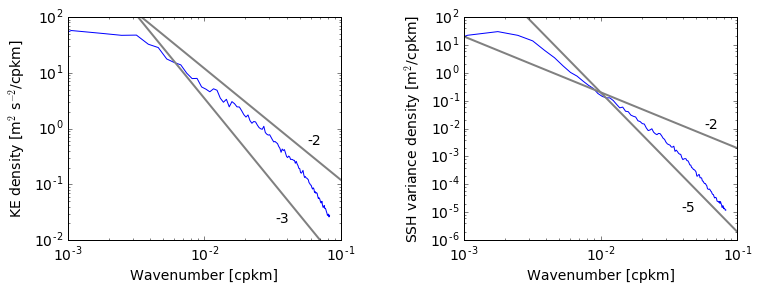

In [18]:
kr = np.array([1.e-4,1.])
e2 = kr**-2/1.e4
e3 = kr**-3/1.e7
e5 = kr**-5/1.e9

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
plt.loglog(specU.ki,iE)
plt.loglog(kr,12.*e2,'.5',linewidth=2); plt.text(1/17.5,5.e-1,'-2',fontsize=14)
plt.loglog(kr,35*e3,'.5',linewidth=2); plt.text(1/30.,2.e-2,'-3',fontsize=14)
plt.xlim(1.e-3,1.e-1)
plt.ylim(1.e-2,1.e2)
plt.xlabel('Wavenumber [cpkm]')
plt.ylabel(r'KE density [m$^2$ s$^{-2}$/cpkm]')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.45, hspace=None)

ax = fig.add_subplot(122)
plt.loglog(specEta.ki,iEeta)
plt.loglog(kr,e2/.5e1,'.5',linewidth=2);    plt.text(1/17.5,1.e-2,'-2',fontsize=14)
plt.loglog(kr,3*e5/1.5e2,'.5',linewidth=2); plt.text(1/25.5,1.e-5,'-5',fontsize=14)
plt.xlim(1.e-3,1.e-1)
plt.ylim(1.e-6,1.e2)
plt.ylabel(r'SSH variance density [m$^2$/cpkm]') 
plt.xlabel('Wavenumber [cpkm]')